# Feature Engineering
Do feature engineering 
- <a href='#1'>1. sliding window</a> 
- <a href='#2'>2. task2</a> 
- <a href='#3'>3. task3</a>

In [8]:
import sys
import os 

import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

sys.path.append('../')
import conf
from utils import (
    check_columns, 
    plot_dist_of_cols,
    check_nan_value,
)

In [2]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(11,4)})

In [3]:
# global variables
DEFAULT_MISSING_VALUE = 0
FONT = fm.FontProperties(fname = os.path.join(conf.LIB_DIR,'simsun.ttc'))
FAULT_LABEL = 1

In [5]:
# functions
def __dummy():
    pass
def _get_skew_kurt_cv(df, cols, window_list, window_size, min_periods, start_index):
    dfs = []
    for i_window in window_list:
        target_df = df[cols].iloc[start_index * i_window * window_size:]
        df_skew = target_df.rolling(i_window * window_size, min_periods=min_periods).skew().iloc[start_index:]
        df_skew.columns = [x + "_skew_" + str(i_window * window_size) for x in df_skew.columns]
        dfs.append(df_skew)
        df_kurt = target_df.rolling(i_window * window_size, min_periods=min_periods).kurt().iloc[start_index:]
        df_kurt.columns = [x + "_kurt_" + str(i_window * window_size) for x in df_kurt.columns]
        dfs.append(df_kurt)
        df_cv = (target_df.rolling(i_window * window_size, min_periods=min_periods).std()/
                 target_df.rolling(i_window * window_size, min_periods=min_periods).mean()).iloc[start_index:]
        df_cv.columns = [x + "_cv_" + str(i_window * window_size) for x in df_cv.columns]
        dfs.append(df_cv)
    return dfs

def _convert_label(fe_df):
        disk_smart_log_df[disk_smart_log_df.tag!=0,'tag'] = FAULT_LABEL
        return disk_smart_log_df 

def _sampling_majority_data(fe_df):
    mask = fe_df==FAULT_LABEL
    majority_df = fe_df[~mask]
    minor_df = fe_df[~mask]
    sub_dfs = dict(tuple(sales_data_df.groupby(['client_id', 'sku_id'])))
    if len(sub_dfs) > max_daily_samples and is_train:
        sample_rate = max_daily_samples * 1.0 / len(sub_dfs)
        sample_dfs = dict([(x, sub_dfs[x]) for x in list(sub_dfs) if np.random.random() < sample_rate])
        sub_dfs = sample_dfs

def _apply_df(args):
    df, is_train = args
    return create_daily_features(df, is_train=is_train)


def feature_engineering_pandas(disk_smart_train_df,
                               disk_smart_test_df,
                               start_date=None, 
                               end_date=None, 
                               is_train=True,
                               use_model_one=True,
                               max_samples=10000):
    """
    
    :return:
    """
    disk_smart_train_df = disk_smart_train_df[disk_smart_train_df.model==1] if use_model_one else disk_smart_train_df 
    disk_smart_train_df = disk_smart_train_df[disk_smart_train_df['date'] >= start_date] if start_date is not None \
    else disk_smart_train_df
    disk_smart_train_df = disk_smart_train_df[disk_smart_train_df['date'] <= end_date] if end_date is not None \
    else disk_smart_train_df
    
#     pool = multiprocessing.Pool(processes=max(1, multiprocessing.cpu_count()-1))
    pool = multiprocessing.Pool(processes=4)
    sub_dfs = dict(tuple(sales_data_df.groupby(['client_id', 'sku_id'])))
    result = pool.map_async(_apply_df, [(sub_dfs[key], is_train) for key in sub_dfs.keys()])
    pool.close()
    ret = pd.concat(list(result.get())).fillna(DEFAULT_MISSING_FLOAT)
    if client_info_df is not None:
        ret = ret.merge(client_info_df, on='client_id', how='left')
    if sku_info_df is not None:
        ret = ret.merge(sku_info_df, on='sku_id', how='left')
    # todo add promo features
    # todo add date context features
    return train_fe_df, test_fe_df

### <a id='1'> 1.slding window</a>

In [7]:
disk_smart_train_df = pd.read_hdf(os.path.join(conf.DATA_DIR, 'data_2018_4_5_6_tag_flag.h5'))

In [11]:
drop_na_cols = check_nan_value(disk_smart_train_df.head())

serial_number - 0.0 
manufacturer - 0.0 
model - 0.0 
dt - 0.0 
smart_1_normalized - 0.0 
smart_3_normalized - 0.0 
smart_4_normalized - 0.0 
smart_5_normalized - 0.0 
smart_7_normalized - 0.0 
smart_9_normalized - 0.0 
smart_10_normalized - 0.0 
smart_12_normalized - 0.0 
smart_184_normalized - 0.0 
smart_187_normalized - 0.0 
smart_188_normalized - 0.0 
smart_189_normalized - 0.0 
smart_190_normalized - 0.0 
smart_191_normalized - 0.0 
smart_192_normalized - 0.0 
smart_193_normalized - 0.0 
smart_194_normalized - 0.0 
smart_195_normalized - 0.0 
smart_197_normalized - 0.0 
smart_198_normalized - 0.0 
smart_199_normalized - 0.0 
smart_240_normalized - 100.0 
smart_241_normalized - 100.0 
smart_242_normalized - 100.0 
tag - 0.0 
flag - 0.0 


In [13]:
disk_smart_train_df.drop(columns=drop_na_cols, inplace=True)

In [15]:
disk_smart_train_df.isna().sum()

serial_number             0
manufacturer              0
model                     0
dt                        0
smart_1_normalized      647
smart_3_normalized      644
smart_4_normalized      668
smart_5_normalized      662
smart_7_normalized      654
smart_9_normalized      641
smart_10_normalized     658
smart_12_normalized     657
smart_184_normalized    671
smart_187_normalized    674
smart_188_normalized    688
smart_189_normalized    686
smart_190_normalized    685
smart_191_normalized    674
smart_192_normalized    675
smart_193_normalized    685
smart_194_normalized    665
smart_195_normalized    672
smart_197_normalized    672
smart_198_normalized    676
smart_199_normalized    669
tag                       0
flag                      0
dtype: int64

In [ ]:
disk_smart

In [20]:
index_cols, cate_cols, cont_cols, label_cols = check_columns(disk_smart_train_df.dtypes.to_dict())

In [21]:
disk_smart_train_df.loc[:,cont_cols] = disk_smart_train_df[cont_cols].fillna(disk_smart_train_df[cont_cols].mean(), inplace=False)

In [23]:
disk_smart_train_df.isna().sum()

serial_number           0
manufacturer            0
model                   0
dt                      0
smart_1_normalized      0
smart_3_normalized      0
smart_4_normalized      0
smart_5_normalized      0
smart_7_normalized      0
smart_9_normalized      0
smart_10_normalized     0
smart_12_normalized     0
smart_184_normalized    0
smart_187_normalized    0
smart_188_normalized    0
smart_189_normalized    0
smart_190_normalized    0
smart_191_normalized    0
smart_192_normalized    0
smart_193_normalized    0
smart_194_normalized    0
smart_195_normalized    0
smart_197_normalized    0
smart_198_normalized    0
smart_199_normalized    0
tag                     0
flag                    0
dtype: int64

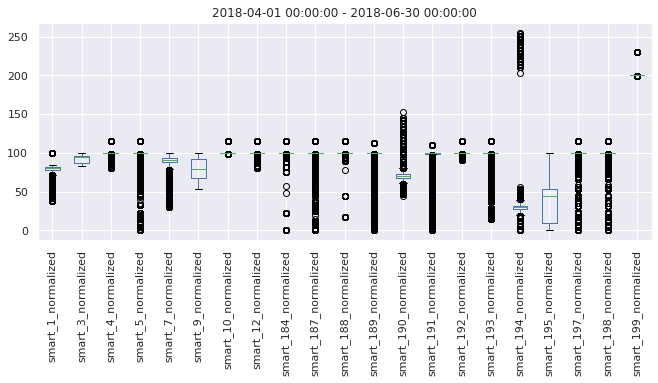

2018-04-01 00:00:00 - 2018-06-30 00:00:00_dist.png has been saved in ../figs/2018-04-01 00:00:00 - 2018-06-30 00:00:00_dist.png 


<Figure size 792x288 with 0 Axes>

In [25]:
plot_dist_of_cols([disk_smart_train_df],cont_cols)

In [28]:
disk_smart_train_df = disk_smart_train_df[disk_smart_train_df.model==1] 

In [29]:
sub_dfs = dict(tuple(disk_smart_train_df.groupby(['manufacturer', 'model','serial_number'])))

In [31]:
sub_dfs[('A', 1, 'disk_100072')]

,serial_number,manufacturer,model,dt,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_195_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,tag,flag
99073,disk_100072,A,1,2018-04-01,75.0,94.0,100.0,100.0,93.0,73.0,100.0,100.0,100.0,100.0,100.0,98.0,67.0,100.0,100.0,100.0,33.0,56.0,100.0,100.0,200.0,0,False
147378,disk_100072,A,1,2018-04-01,82.0,94.0,100.0,100.0,93.0,73.0,100.0,100.0,100.0,100.0,100.0,98.0,67.0,100.0,100.0,100.0,33.0,54.0,100.0,100.0,200.0,0,False
243964,disk_100072,A,1,2018-04-02,81.0,94.0,100.0,100.0,93.0,73.0,100.0,100.0,100.0,100.0,100.0,98.0,67.0,100.0,100.0,100.0,33.0,55.0,100.0,100.0,200.0,0,False
291914,disk_100072,A,1,2018-04-02,78.0,94.0,100.0,100.0,93.0,74.0,100.0,100.0,100.0,100.0,100.0,98.0,67.0,100.0,100.0,100.0,33.0,48.0,100.0,100.0,200.0,0,False
291915,disk_100072,A,1,2018-04-02,81.0,94.0,100.0,100.0,93.0,73.0,100.0,100.0,100.0,100.0,100.0,98.0,67.0,100.0,100.0,100.0,33.0,54.0,100.0,100.0,200.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2796846,disk_100072,A,1,2018-06-19,79.0,94.0,100.0,100.0,94.0,72.0,100.0,100.0,100.0,100.0,100.0,98.0,67.0,100.0,100.0,100.0,33.0,55.0,100.0,100.0,200.0,0,False
2796847,disk_100072,A,1,2018-06-19,82.0,94.0,100.0,100.0,94.0,71.0,100.0,100.0,100.0,100.0,100.0,98.0,67.0,100.0,100.0,100.0,33.0,53.0,100.0,100.0,200.0,0,False
2796848,disk_100072,A,1,2018-06-19,84.0,94.0,100.0,100.0,94.0,72.0,100.0,100.0,100.0,100.0,100.0,98.0,67.0,100.0,100.0,100.0,33.0,55.0,100.0,100.0,200.0,0,False
2893079,disk_100072,A,1,2018-06-19,83.0,94.0,100.0,100.0,94.0,72.0,100.0,100.0,100.0,100.0,100.0,98.0,68.0,100.0,100.0,100.0,32.0,55.0,100.0,100.0,200.0,0,False


In [34]:
disk_smart_train_df.loc[disk_smart_train_df.serial_number == 'disk_100070']

,serial_number,manufacturer,model,dt,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_195_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,tag,flag
51136,disk_100070,A,1,2018-04-01,82.0,94.0,100.0,100.0,92.0,74.0,100.0,100.0,100.0,100.0,100.0,100.0,76.0,100.0,100.0,100.0,24.0,64.0,100.0,100.0,200.0,0,False
147377,disk_100070,A,1,2018-04-01,78.0,94.0,100.0,100.0,91.0,74.0,100.0,100.0,100.0,100.0,100.0,100.0,76.0,100.0,100.0,100.0,24.0,61.0,100.0,100.0,200.0,0,False
340009,disk_100070,A,1,2018-04-03,71.0,94.0,100.0,100.0,91.0,75.0,100.0,100.0,100.0,100.0,100.0,100.0,76.0,100.0,100.0,100.0,24.0,64.0,100.0,100.0,200.0,0,False
481025,disk_100070,A,1,2018-04-04,81.0,94.0,100.0,100.0,91.0,74.0,100.0,100.0,100.0,100.0,100.0,100.0,76.0,100.0,100.0,100.0,24.0,56.0,100.0,100.0,200.0,0,False
807611,disk_100070,A,1,2018-04-06,75.0,94.0,100.0,100.0,91.0,75.0,100.0,100.0,100.0,100.0,100.0,100.0,76.0,100.0,100.0,100.0,24.0,63.0,100.0,100.0,200.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536228,disk_100070,A,1,2018-06-17,81.0,94.0,100.0,100.0,92.0,72.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,60.0,100.0,100.0,200.0,0,False
2728037,disk_100070,A,1,2018-06-18,81.0,94.0,100.0,100.0,92.0,72.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,64.0,100.0,100.0,200.0,0,False
2941252,disk_100070,A,1,2018-06-20,83.0,94.0,100.0,100.0,92.0,73.0,100.0,100.0,100.0,100.0,100.0,100.0,75.0,100.0,100.0,100.0,25.0,64.0,100.0,100.0,200.0,0,False
2941253,disk_100070,A,1,2018-06-20,83.0,94.0,100.0,100.0,92.0,72.0,100.0,100.0,100.0,100.0,100.0,100.0,75.0,100.0,100.0,100.0,25.0,63.0,100.0,100.0,200.0,0,False
